In [1]:
from urllib.parse import quote
import os
from dotenv import load_dotenv
load_dotenv()

### Preparing the data

> This dataset is queried through the MySQL server using the given query below (the data collected using the OntarioDataPipeline project). Then the result was saved into CSV file for easy analysis purposes.

#### The following SQL Query was used to retrieve the data:
````
SELECT rl.Id, rl.CityName, rl.Beds, rl.Baths,
rl.ListingType, rl.Area, cd.PopulationLatest,
COUNT(DISTINCT rls.SchoolId) AS Schools,
COUNT(DISTINCT rlc.CollegeName) AS Colleges,
COUNT(DISTINCT rlu.UniversityName) AS Universities,
COUNT(DISTINCT rlam.YelpDataId) AS Ameneties,
COUNT(DISTINCT rlab.AirbnbId) AS Airbnbs,
rl.CityName, ROUND(AVG(rla.Price), 0) AS Price,
cd.AveragePrice,
(CASE
    WHEN ROUND(AVG(rla.Price), 0) > cd.AveragePrice THEN 'A'
    WHEN ROUND(AVG(rla.Price), 0) < cd.AveragePrice THEN 'B'
END) AS AboveBelowAverage
FROM RemaxListingsAssociations rla 
INNER JOIN RemaxListings rl ON rl.Id = rla.Id
INNER JOIN CitiesData cd ON rl.CityName = cd.CityName
LEFT JOIN RemaxListingsSchools rls  ON
rl.Id = rls.Id
LEFT JOIN RemaxListingsColleges rlc ON
rl.Id = rlc.Id
LEFT JOIN RemaxListingsUniversities rlu ON
rl.Id = rlu.Id
LEFT JOIN RemaxListingsAmeneties rlam ON
rl.Id = rlam.Id
LEFT JOIN RemaxListingsAirbnb rlab ON
rl.Id = rlab.Id
WHERE rl.Area IS NOT NULL
AND rl.Area > 100
AND rla.Price > 1000
AND rl.Beds IS NOT NULL
AND rl.Baths IS NOT NULL
GROUP BY rl.Id
````

In [2]:
import pandas as pd

df = pd.read_csv("RealEstateData-AboveBelowAvg.csv")
df = df.drop(['Id', 'CityName'], axis=1)
df = df[df['AboveBelowAvg'].notna()]
df

,Beds,Baths,ListingType,Area,Population,Schools,Colleges,Universities,Amenties,Airbnbs,Price,AveragePrice,AboveBelowAvg
0,4,3,Single Family,1434,7967,5,0,0,22,9,849900,708019.0,A
1,4,3,Single Family,1437,7967,5,0,0,12,9,879900,708019.0,A
2,4,3,Single Family,2000,11485,2,0,0,16,16,899000,894860.0,A
3,4,4,Single Family,3840,32721,0,0,0,0,0,2300000,752855.0,A
4,2,2,Single Family,1149,94415,4,0,0,6,2,6295,593623.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,5,7,Single Family,1071,422324,14,1,0,62,24,699800,691690.0,A
1796,2,2,Condo,1300,11059,5,0,0,47,31,781567,543702.0,A
1797,2,3,Single Family,1492,2650,0,0,0,0,0,699000,1132967.0,B
1798,4,3,Rental,2843,9390,0,0,0,24,69,3500,1066799.0,B


### One-Hot Encoding

> The given categorical data which is "ListingType" is string/alphabetic form. To convert into numerical form (to use it for statistical purposes) one-hot encoding is used.

+ #### Viewing the unique values in the column

> This gives us an idea how many extra columns will be added when each unique value is one-hot encoded.

In [3]:
print(df['ListingType'].unique())

['Single Family' 'Rental' 'Condo' 'Multi-Family' 'Farm' 'Condo/Townhome'
 'Townhome']


+ #### Viewing the number of values for each category

> Finding out the number of occurences of each category in the table helps us find out if that column is worth adding or not.

In [4]:
df['ListingType'].value_counts()

ListingType
Single Family     1266
Condo              302
Multi-Family       104
Rental              81
Farm                18
Condo/Townhome      17
Townhome             1
Name: count, dtype: int64

+ #### Creating One-Hot encoded columns

> Adding dummy data for each column.

In [5]:
df['AboveBelowAvg'] = (df['AboveBelowAvg'] == 'A').astype(int)

In [6]:
df_updated = pd.get_dummies(df, columns=['ListingType'], dtype=int)

#Move the price column at the end as its the dependent variable
column = df_updated.pop('AboveBelowAvg')
df_updated.insert(len(df_updated.columns), 'AboveBelowAvg', column)
df_updated

,Beds,Baths,Area,Population,Schools,Colleges,Universities,Amenties,Airbnbs,Price,AveragePrice,ListingType_Condo,ListingType_Condo/Townhome,ListingType_Farm,ListingType_Multi-Family,ListingType_Rental,ListingType_Single Family,ListingType_Townhome,AboveBelowAvg
0,4,3,1434,7967,5,0,0,22,9,849900,708019.0,0,0,0,0,0,1,0,1
1,4,3,1437,7967,5,0,0,12,9,879900,708019.0,0,0,0,0,0,1,0,1
2,4,3,2000,11485,2,0,0,16,16,899000,894860.0,0,0,0,0,0,1,0,1
3,4,4,3840,32721,0,0,0,0,0,2300000,752855.0,0,0,0,0,0,1,0,1
4,2,2,1149,94415,4,0,0,6,2,6295,593623.0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,5,7,1071,422324,14,1,0,62,24,699800,691690.0,0,0,0,0,0,1,0,1
1796,2,2,1300,11059,5,0,0,47,31,781567,543702.0,1,0,0,0,0,0,0,1
1797,2,3,1492,2650,0,0,0,0,0,699000,1132967.0,0,0,0,0,0,1,0,0
1798,4,3,2843,9390,0,0,0,24,69,3500,1066799.0,0,0,0,0,1,0,0,0


Comparing Price and Beds where Beds is the explanatory variable X and AboveBelowAvg is the dependant variable.



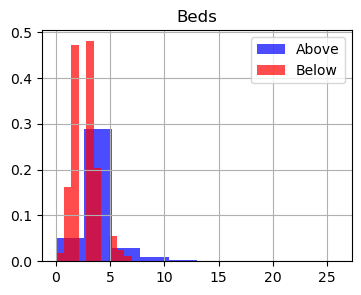

#################################################### END ####################################################

Comparing Price and Baths where Baths is the explanatory variable X and AboveBelowAvg is the dependant variable.



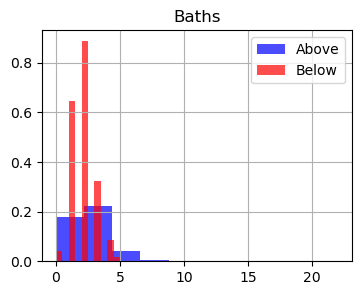

#################################################### END ####################################################

Comparing Price and Area where Area is the explanatory variable X and AboveBelowAvg is the dependant variable.



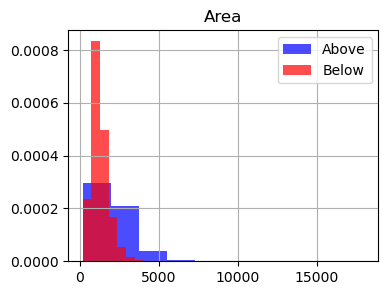

#################################################### END ####################################################

Comparing Price and Population where Population is the explanatory variable X and AboveBelowAvg is the dependant variable.



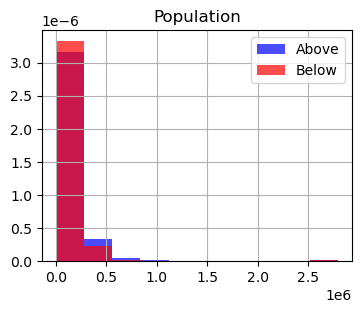

#################################################### END ####################################################

Comparing Price and Schools where Schools is the explanatory variable X and AboveBelowAvg is the dependant variable.



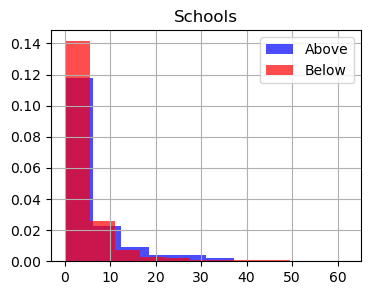

#################################################### END ####################################################

Comparing Price and Colleges where Colleges is the explanatory variable X and AboveBelowAvg is the dependant variable.



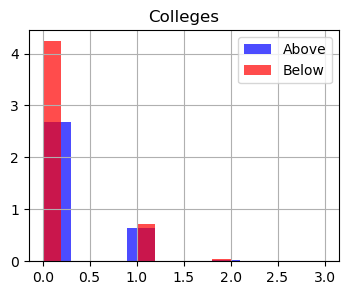

#################################################### END ####################################################

Comparing Price and Universities where Universities is the explanatory variable X and AboveBelowAvg is the dependant variable.



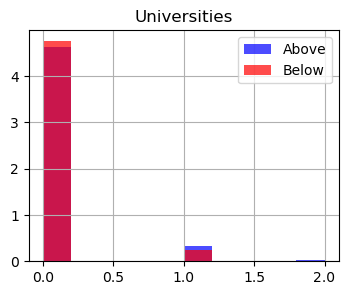

#################################################### END ####################################################

Comparing Price and Amenties where Amenties is the explanatory variable X and AboveBelowAvg is the dependant variable.



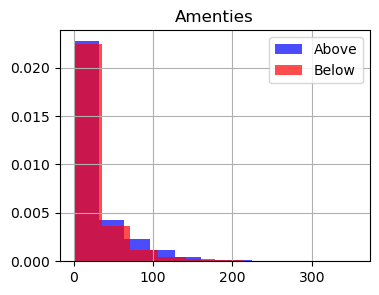

#################################################### END ####################################################

Comparing Price and Airbnbs where Airbnbs is the explanatory variable X and AboveBelowAvg is the dependant variable.



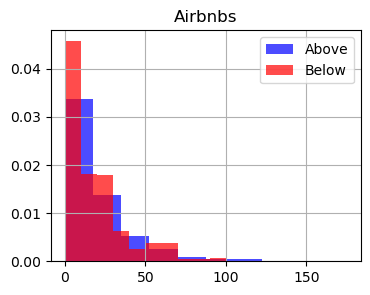

#################################################### END ####################################################

Comparing Price and Price where Price is the explanatory variable X and AboveBelowAvg is the dependant variable.



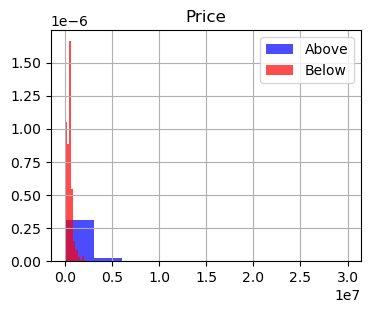

#################################################### END ####################################################

Comparing Price and AveragePrice where AveragePrice is the explanatory variable X and AboveBelowAvg is the dependant variable.



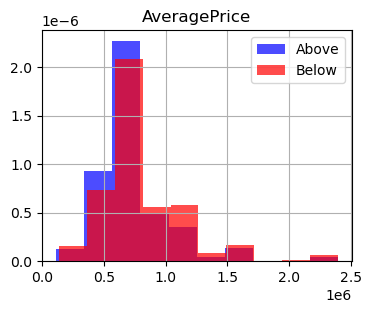

#################################################### END ####################################################

Comparing Price and ListingType_Condo where ListingType_Condo is the explanatory variable X and AboveBelowAvg is the dependant variable.



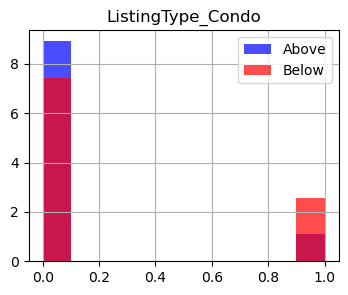

#################################################### END ####################################################

Comparing Price and ListingType_Condo/Townhome where ListingType_Condo/Townhome is the explanatory variable X and AboveBelowAvg is the dependant variable.



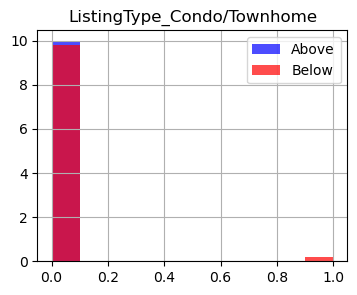

#################################################### END ####################################################

Comparing Price and ListingType_Farm where ListingType_Farm is the explanatory variable X and AboveBelowAvg is the dependant variable.



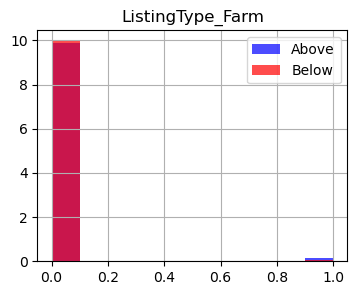

#################################################### END ####################################################

Comparing Price and ListingType_Multi-Family where ListingType_Multi-Family is the explanatory variable X and AboveBelowAvg is the dependant variable.



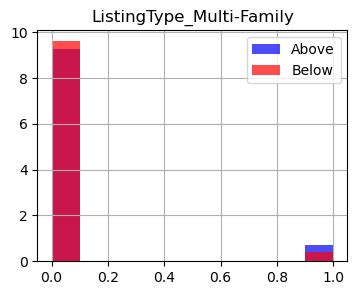

#################################################### END ####################################################

Comparing Price and ListingType_Single Family where ListingType_Single Family is the explanatory variable X and AboveBelowAvg is the dependant variable.



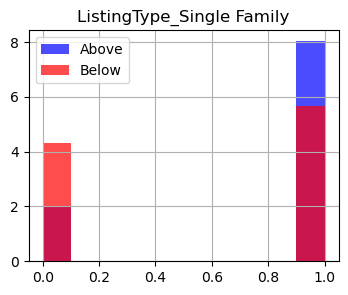

#################################################### END ####################################################



In [7]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np

for label in df_updated.columns[:-1]:
    if label != 'AboveBelowAvg' and 'ListingType_Rental' not in label  and  'ListingType_Townhome' not in label:
        warnings.simplefilter(action='ignore', category=FutureWarning)
        print(f'Comparing Price and {label} where {label} is the explanatory variable X and AboveBelowAvg is the dependant variable.\n')
        plt.figure(figsize=(4, 3))
        plt.title(label)
        plt.hist(df_updated[df_updated['AboveBelowAvg']==1][label], color='blue', label='Above', alpha=0.7, density=True)
        plt.hist(df_updated[df_updated['AboveBelowAvg']==0][label], color='red', label='Below', alpha=0.7, density=True)
        plt.legend()
        plt.grid(True)
        plt.show()
        print('#################################################### END ####################################################\n')


### Preparing Train, Validation and Test Datasets
> Below we will be dividing our data with different ratio for training, validation and testing respectively. The data will split using the following ratio:
> + Train: 60%
> + Validation: 20% (From 60% to 80%)
> + Testing: 20% (The left over data from 80% to 100%)

In [8]:
train, valid, test = np.split(df_updated.sample(frac=1), [int(0.6*len(df_updated)), int(0.8*len(df_updated))])

#### Preparing the data: 
> Part of data prepration process is to standardize and normalize the data for the following reasons:
>
> Standardization:
>
> + The goal of standardization is to rescale the features such that they have a mean of 0 and a standard deviation of 1. This is also known as z-score normalization.
> + Standardization is particularly useful when the features in your dataset have different scales. It helps algorithms that are sensitive to the scale of the features (e.g., gradient descent-based algorithms) converge faster and perform better
> 
> Normalization:
>
> + The goal of normalization is to rescale the features to a specific range, usually [0, 1].
> + Normalization is useful when the features have different ranges, and you want to bring them to a common scale. It is often used in algorithms that rely on distances or gradients and can be sensitive to the scale of the features.
>
> The following python modules are used for this:
> + numpy.hstack(): This function is used to stack the sequence of input arrays horizontally (i.e. column wise) to make a single array.
> + StandardScaler(): This will normalize the features i.e. each column of X, INDIVIDUALLY, so that each column/feature/variable will have μ = 0 and σ = 1.

In [9]:
from sklearn.preprocessing import StandardScaler

def scale_dataset(dataframe):
  X = dataframe[dataframe.columns[:-1]].values
  Y = dataframe[dataframe.columns[-1]].values
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  # Reshape the dataset
  data = np.hstack((X, np.reshape(Y, (-1, 1))))
  return data, X, Y

In [10]:
train, x_train, y_train = scale_dataset(df_updated)
valid, x_valid, y_valid = scale_dataset(df_updated)
test, x_test, y_test = scale_dataset(df_updated)

### K-Nearest Neighbor

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [12]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train, y_train)

KNeighborsClassifier()

In [16]:
y_predictions = knn_model.predict(x_test)
print('################ Classification Report ################\n')
print(classification_report(y_test, y_predictions))
print('#######################################################\n')

################ Classification Report ################

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       720
           1       0.89      0.91      0.90      1069

    accuracy                           0.87      1789
   macro avg       0.87      0.87      0.87      1789
weighted avg       0.87      0.87      0.87      1789

#######################################################



#### Understanding Classification Report

The report presents the main classification metrics—precision, recall, and F1-score—for each class. These metrics are calculated using true and false positives, along with true and false negatives. In this context, “positive” and “negative” are simply generic terms used for the predicted classes.
<br>
To assess whether a prediction is correct or incorrect, we consider four possible outcomes: <br>
1. <b>TN / True Negative: </b>The model correctly predicts a negative class for a negative case.
2. <b>TP / True Positive: </b>The model correctly predicts a positive class for a positive case.
3. <b>FN / False Negative: </b>The model incorrectly predicts a negative class for a positive case.
4. <b>FP / False Positive: </b>The model incorrectly predicts a positive class for a negative case.

##### Precision – What percent of your predictions were correct?

> Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class it is defined as the ratio of true positives to the sum of true and false positives.

##### Recall – What percent of the positive cases did you catch? 
> Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.
Recall: Fraction of positives that were correctly identified.

<img src="./images/Precisionrecall.svg.png" alt="Formula" width="300" height="600"/>

#### F1 score – What percent of positive predictions were correct? 
> The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.